In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import requests
import json
import re

In [44]:
# url_path = "https://www.land.mlit.go.jp/webland/api/TradeListSearch?from=20171&to=20184&area=13"
# request_result = requests.get(url_path)
# data_json = request_result.json()["data"]
# print(len(data_json))
# print(data_json[0])

In [45]:
# data_pd = pd.io.json.json_normalize(data_json)
# print(data_pd.shape)
# print(data_pd.head(10))
# https://www.land.mlit.go.jp/webland/api.html
# https://www.land.mlit.go.jp/webland/download.html

In [46]:
data_from_csv = pd.read_csv("data/13_Tokyo_20171_20184.csv", encoding='cp932')
# print(data_from_csv.shape)
# print(data_from_csv.iloc[0])
# print(data_from_csv.head(10))
# print(data_from_csv["種類"].unique())

In [47]:
data_used_apartment = data_from_csv.query('種類 == "中古マンション等"')
# print(data_used_apartment.shape)
# print(data_used_apartment.isnull().sum())

In [48]:
columns_name_list = ["最寄駅：距離（分）", "間取り", "面積（㎡）", "建築年", "建物の構造", "建ぺい率（％）", "容積率（％）", "市区町村名", "取引価格（総額）"]
data_selected = data_used_apartment[columns_name_list]
print(data_selected.shape)

data_selected_dropna = data_selected.dropna(how='any') # 1つでもNaNデータを含む行を削除
print(data_selected_dropna.shape)
print(data_selected_dropna.iloc[0])

(30956, 9)
(28442, 9)
最寄駅：距離（分）           3
間取り              １ＬＤＫ
面積（㎡）              35
建築年             昭和60年
建物の構造             ＳＲＣ
建ぺい率（％）            80
容積率（％）            700
市区町村名            千代田区
取引価格（総額）     24000000
Name: 0, dtype: object


In [49]:
# print(data_selected_dropna["建築年"].unique())
data_selected_dropna = data_selected_dropna[data_selected_dropna["建築年"].str.match('^平成|昭和')]
# print(data_selected_dropna["建築年"].unique())

wareki_to_seireki = {'昭和': 1926-1, '平成': 1989-1}

building_year_list = data_selected_dropna["建築年"]

building_age_list = []
for building_year in building_year_list:
    # 昭和x年 -> 昭和, xに変換、平成x年 -> 平成, xに変換
    building_year_split = re.search(r'(.+?)([0-9]+|元)年', building_year)
    # 西暦に変換
    seireki = wareki_to_seireki[building_year_split.groups()[0]] + int(building_year_split.groups()[1])

    building_age = 2019 - seireki
    building_age_list.append(building_age)

data_selected_dropna["築年数"] = building_age_list
data_added_building_age = data_selected_dropna.drop("建築年", axis=1)
# print(data_added_building_age.head())

In [50]:
columns_name_list = ["最寄駅：距離（分）", "面積（㎡）", "築年数", "建ぺい率（％）", "容積率（％）", "取引価格（総額）"]
dummy_list = ["間取り", "建物の構造", "市区町村名"]

data_added_dummies = pd.concat([data_added_building_age[columns_name_list], pd.get_dummies(data_added_building_age[dummy_list], drop_first=True)], axis=1)

# print(data_added_dummies.shape)
# print(data_added_dummies.iloc[0])
# print(data_added_dummies.dtypes)
data_added_dummies["面積（㎡）"] = data_added_dummies["面積（㎡）"].astype(float)
data_added_dummies = data_added_dummies[~data_added_dummies["最寄駅：距離（分）"].str.contains('\?')]
data_added_dummies["最寄駅：距離（分）"] = data_added_dummies["最寄駅：距離（分）"].astype(float)
# print(data_added_dummies.head(3))
# ここまで前処理

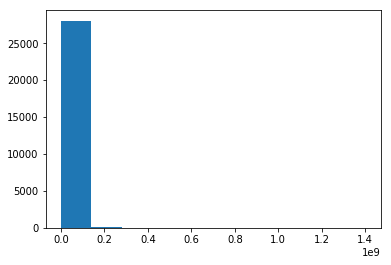

In [52]:
plt.hist(data_added_dummies["取引価格（総額）"])
plt.show()

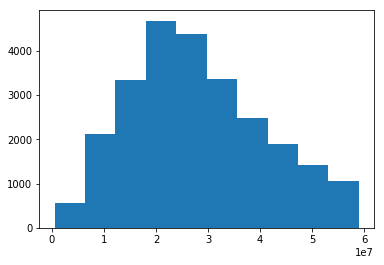

In [56]:
tmp_data = data_added_dummies[data_added_dummies["取引価格（総額）"] < 60000000]
# print(tmp_data.shape)
plt.hist(tmp_data["取引価格（総額）"])
plt.show()

In [57]:
data_added_dummies = data_added_dummies[data_added_dummies["取引価格（総額）"] < 60000000]

In [58]:
lr = LinearRegression()

x_column_list = ["面積（㎡）"]
y_column_list = ["取引価格（総額）"]

x = data_added_dummies[x_column_list]
y = data_added_dummies[y_column_list]

lr.fit(x, y)

# print(lr.coef_)
# print(lr.intercept_)

[[ 340164.35773432]]
[ 13338124.58515109]


In [59]:
x = data_added_dummies.drop("取引価格（総額）", axis=1)
y = data_added_dummies["取引価格（総額）"]

print(x.head())
print(y.head())

最寄駅：距離（分）  面積（㎡）  築年数  建ぺい率（％）  容積率（％）  間取り_スタジオ  間取り_１ＤＫ  間取り_１ＤＫ＋Ｓ  \
0        3.0   35.0   34     80.0   700.0         0        0          0   
1        4.0   20.0   37     80.0   700.0         0        0          0   
3        3.0   30.0   34     80.0   700.0         0        0          0   
5        3.0   25.0   34     80.0   700.0         0        0          0   
7        4.0   45.0   37     80.0   700.0         0        0          0   

   間取り_１Ｋ  間取り_１Ｋ＋Ｓ    ...      市区町村名_練馬区  市区町村名_羽村市  市区町村名_荒川区  市区町村名_葛飾区  \
0       0         0    ...              0          0          0          0   
1       1         0    ...              0          0          0          0   
3       1         0    ...              0          0          0          0   
5       1         0    ...              0          0          0          0   
7       0         0    ...              0          0          0          0   

   市区町村名_西多摩郡瑞穂町  市区町村名_西東京市  市区町村名_調布市  市区町村名_豊島区  市区町村名_足立区  市区町村名_青梅市  
0       

In [61]:
lr_multi = LinearRegression()
lr_multi.fit(x, y)

print(lr_multi.coef_)
print(lr_multi.intercept_)
# ここまで分析

[ -3.21075099e+05   3.76053522e+05  -4.48631860e+05  -2.90147041e+04
   4.31534605e+03   4.61717516e+06   4.13966167e+06   2.33397066e+06
   9.69138736e+05   3.63490098e+06   8.21792962e+06   9.93289243e+06
   1.00214843e+06   6.63336211e+06   8.52563757e+06   5.04054279e+06
   7.92421156e+06   9.75297905e+06   7.19969604e+06   5.62790618e+06
   1.79636580e+06   5.35055842e+06   7.96156975e+06   9.59262252e-07
   7.60795419e+06   5.47961172e+06   8.26278177e+05   7.55669927e+06
   6.02023844e+06  -9.20104592e+06   1.80466576e+06   6.92109852e+06
   7.06546839e+06   1.63529543e+07   7.22112604e+06   6.01803260e+06
   7.55835526e+06   3.21420909e+07   3.45910454e+07   3.47187516e+07
   3.27950343e+07   1.46932369e+07   2.90250528e+07   3.55943063e+07
   3.00373137e+07   3.39724680e+07   2.59447135e+07   2.56211949e+07
   2.95410844e+07   1.73446034e+07   3.02660427e+07   1.81401584e+07
   2.77469950e+07   2.23476801e+07   3.41097703e+07   3.46579114e+07
   1.76688956e+07   1.30668874e+07

In [62]:
X = data_added_dummies.drop("取引価格（総額）", axis=1)
y = data_added_dummies["取引価格（総額）"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(17693, 86)
(7584, 86)
(17693,)
(7584,)


In [64]:
lr_multi2 = LinearRegression()

lr_multi2.fit(X_train, y_train)
# print(lr_multi2.coef_)
# print(lr_multi2.intercept_)

[ -3.10839361e+05   3.63185468e+05  -4.49907928e+05  -3.19885805e+04
   4.52011158e+03   4.34554831e+06   4.12447208e+06   1.05894397e+06
   8.10303547e+05   3.78784008e+06   8.28546231e+06   1.00259748e+07
   7.76279645e+05   6.72588341e+06   8.40959942e+06   5.67558861e+06
   8.15055454e+06   1.00551838e+07   7.15848999e+06   5.78727572e+06
   8.98260623e-07   6.44514108e+06   8.44747742e+06   3.13110650e-06
   8.52747385e+06   4.75447255e+06   4.38409549e+06   7.84587222e+06
   6.83575428e+06  -8.45602878e+06   9.80049984e+05   2.24366388e+06
   2.27212055e+06   1.03519992e+07   2.41711055e+06  -1.14725871e+06
   1.41883912e+06   3.17025428e+07   3.45700665e+07   3.48369084e+07
   3.28991270e+07   1.49917232e+07   2.91527394e+07   3.60348667e+07
   2.99720155e+07   3.42093826e+07   2.58179444e+07   2.58788182e+07
   2.95833240e+07   1.76961723e+07   3.03445514e+07   1.83896986e+07
   2.83504386e+07   2.26462219e+07   3.42149392e+07   3.45301650e+07
   1.80376227e+07   1.29781850e+07

In [67]:
y_pred = lr_multi2.predict(X_test)
# print(y_pred-y_test)

In [68]:
from sklearn.metrics import mean_absolute_error

x_column_list = ["面積（㎡）"]
y_column_list = ["取引価格（総額）"]

X_train, X_test, y_train, y_test = train_test_split(data_added_dummies[x_column_list], data_added_dummies[y_column_list], test_size=0.3)

lr_single = LinearRegression()

lr_single.fit(X_train, y_train)
y_pred = lr_single.predict(X_test)

print(mean_absolute_error(y_pred, y_test))

8193392.13099


In [69]:
x = data_added_dummies.drop("取引価格（総額）", axis=1)
y = data_added_dummies["取引価格（総額）"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

lr_multi2 = LinearRegression()

lr_multi2.fit(X_train, y_train)
y_pred = lr_multi2.predict(X_test)

print(mean_absolute_error(y_pred, y_test))

4617562.00744
